In [2]:
def get_ontology_indices(ont_rem_file, num_obs):
    # Load the CSV file using genfromtxt
    data = np.genfromtxt(ont_rem_file, delimiter=',')
    indices_backup = data # indices of data deferred to neural network backup
    
    full_sequence = np.arange(num_obs*3)
    
    # Calculate the inverse of the original array
    indices_ont = np.setdiff1d(full_sequence, indices_backup) # indices of data predicted by ontology
    
    return indices_backup, indices_ont

In [29]:
import numpy as np

rem_2016, ont_2016 = get_ontology_indices('data/rem2016.csv', 650)
rem_2015, ont_2015 = get_ontology_indices('data/rem2015.csv', 597)

In [4]:
# Get prediction-truth pairs 
def get_pred(file_path):
    with open(file_path) as f:
        lines = f.readlines()
        return np.array([line.split('\t') for line in lines])[:,:2]
    
# Filter out examples that have already been predicted by the ontology
def mask_predictions(pred_array, rem_array):
    return np.array([pair for i, pair in enumerate(pred_array) if i*3 in rem_array])

# Get prediction accuracy
def get_acc(pred_array):
    count = np.sum(pred_array[:,0] == pred_array[:,1])
    acc = count / pred_array.shape[0]
    return acc

def print_result(acc, backup_acc, combined_acc):
    print(f'''Neural network accuracy (full sample): {100 * acc:.2f}%\nNeural network accuracy (as backup): {100 * backup_acc:.2f}%\nCombined ontology and nn accuracy: {100 * combined_acc:.2f}%\n\n''')

In [5]:
# Extracting eval files

In [6]:
import os
import glob


def get_eval_paths(directory_path):
    # Get a list of all subdirectories
    subdirectories = [subdir for subdir in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, subdir))]

    file_paths = {'2015': [], '2016': []}

    # Iterate through each subdirectory
    for subdir in subdirectories:
        year = subdir[:4]
        # Get a list of all .txt files in the subdirectory
        txt_files = glob.glob(os.path.join(directory_path, subdir, 'epoch_*_eval.txt'))
        if txt_files:
            # Extract the highest {n} value from the file names
            n_values = [int(os.path.splitext(os.path.basename(txt_file))[0].split('_')[1]) for txt_file in txt_files]
            highest_n = max(n_values)

            # Construct the file name of the .txt file with the highest {n}
            highest_n_file = os.path.join(directory_path, subdir, f'epoch_{highest_n}_eval.txt')

            # Do something with the highest_n_file
            file_paths[year].append(highest_n_file)
    return file_paths

In [7]:
directory = 'test_models'
accuracyOnt2016 = 0.868159
accuracyOnt2016_full = 0.783077
accuracyOnt2015 = 0.827703
accuracyOnt2015_full = 0.658291
accuracyOnt = {'2015': 0.827703, '2016': 0.868159}
accuracyOnt_full = {'2015': 0.658291, '2016': 0.783077}

def eval_file(f, year):
    if year == '2015':
        rem = rem_2015
        num_obs = 597
    elif year == '2016':
        rem = rem_2016
        num_obs = 650

    num_backup_predictions = len(rem) // 3
    num_ont_predictions = num_obs - num_backup_predictions

    # Get predictions
    pred_arr = get_pred(f)
    backup_pred_arr = mask_predictions(pred_arr, rem)

    # Get accuracy
    acc = get_acc(pred_arr)
    backup_acc = get_acc(backup_pred_arr)

    combined_acc = (num_ont_predictions * accuracyOnt[year] + num_backup_predictions * backup_acc) / num_obs
    
    return acc, backup_acc, combined_acc

def f1_file(f):
    pred_arr = get_pred(f)


def eval_files_from_directory(directory):
    for f in os.listdir(directory):
        if f.endswith('.txt'):
            year = f[:4]
            if year == '2015':
                rem = rem_2015
                num_obs = 597
            elif year == '2016':
                rem = rem_2016
                num_obs = 650
                
            num_backup_predictions = len(rem) // 3
            num_ont_predictions = num_obs - num_backup_predictions
            
            file_path = os.path.join(directory, f)
            
            # Get predictions
            pred_arr = get_pred(file_path)
            backup_pred_arr = mask_predictions(predd_arr, rem)
            
            # Get accuracy
            acc = get_acc(pred_arr)
            backup_acc = get_acc(backup_pred_arr)
            
            combined_acc = (num_ont_predictions * accuracyOnt[year] + num_backup_predictions * backup_acc)
            
            return acc, backup_acc, combined_acc
        

            

In [8]:
import re
# full_sample/2016tri_gcn+concat_seed683_reg0.004_drop0.2_cdrop0.4_lr2e-05_epochs25_adam_2-2-2/epoch_24_eval.txt
def extract_info(file_path, folder):
    # Extract information from the file path using regular expressions
#     print('file path: ', file_path)
    match = re.search(fr'{folder}/(\d+)([a-zA-Z+_.]+)_seed(\d+)_reg((?:\d+\.\d+e[+-]\d+)|(?:[\d.]+))_drop([\d.]+)_cdrop([\d.]+)_lr([\d.e-]+)_epochs(\d+)_([a-zA-Z]+)(_\d)*.*', file_path)
    test_match = re.search(r'full_sample/(\d+)([a-zA-Z+_.]+)_seed(\d+)_reg((?:\d+\.\d+e[+-]\d+)|(?:[\d.]+))_drop([\d.]+)_cdrop([\d.]+)_lr([\d.e-]+)_epochs(\d+)_([a-zA-Z]+)(_\d)*.*', file_path)
#     print(test_match)
    if match: 
#         print('Match!')
        year = match.groups()[0]
        model_type = match.groups()[1]
        seed = match.groups()[2]
        reg = match.groups()[3]
        drop = match.groups()[4]
        cdrop = match.groups()[5]
        lr = match.groups()[6]
        epochs = match.groups()[7]
    else:
#         print('No match!')
        return None 
#     match = re.search(r'test_models/(\d+)([a-zA-Z+]+)_seed(\d+)_reg([\d.]+)_drop([\d.]+)_cdrop([\d.]+)_lr([\d.e-]+)_epochs(\d+)', file_path)
#     year = match.group(1)
#     model_type = match.group(2)
#     seed = match.group(3)
#     reg = match.group(4)
#     drop = match.group(5)
#     cdrop = match.group(6)
#     lr = match.group(7)
#     epochs = match.group(8)
    
    # Call get_acc(file_path) to obtain the accuracy values
#     print('year:',year)

    acc, backup_acc, combined_acc = eval_file(f, year)
    return year, model_type, acc, backup_acc, combined_acc, seed, reg, drop, cdrop, lr, epochs

In [31]:
import pandas as pd

# Directory path
directory_path = 'test_models'

file_paths = get_eval_paths(directory_path)
# print([s.split("_")[-2] for s in file_paths['2016']])
# print(file_paths['2016'])

# df to store info
columns = ['Year', 'Model Type', 'Acc.', 'Backup acc.', 'Combined acc.', 'Seed', 'Reg', 'Drop', 'CDrop', 'LR', 'Epochs']
results = pd.DataFrame(columns=columns)

year = '2016'

for f in file_paths[year]:
    info = extract_info(f, directory_path)
    if info:
        results.loc[len(results)] = info
    
# Convert strings to numerics
columns_to_convert = ['Year', 'Acc.', 'Backup acc.', 'Combined acc.', 'Seed', 'Reg', 'Drop', 'CDrop', 'LR', 'Epochs']
results[columns_to_convert] = results[columns_to_convert].apply(pd.to_numeric, errors='coerce')
    
best_acc = max(results['Acc.'])
best_combined_acc = max(results['Combined acc.'])



print(f'Year: {year}\nNumber of models: {len(results)}\n\nBest accuracy: {best_acc:.4f}\nBest combined accuracy: {best_combined_acc:.4f}')

cdrop_0 = results.loc[results['CDrop'] == 0]
cdrop_0_3 = results.loc[results['CDrop'] == 0.3]
cdrop_0_5 = results.loc[results['CDrop'] == 0.5]

print(f'Standard deviation: {results["Combined acc."].std()}')

# print(f'0.0 cdrop: {cdrop_0["Combined acc."].mean():.4f}')
# print(f'0.3 cdrop: {cdrop_0_3["Combined acc."].mean():.4f}')
# print(f'0.5 cdrop: {cdrop_0_5["Combined acc."].mean():.4f}')

gate_models = results.loc[results['Model Type'] == 'tgcn+sem+gate']
concat_models = results.loc[results['Model Type'] == 'tgcn+sem+concat']

print(f'\nNumber of gate models: {len(gate_models)}\nNumber of concat. models: {len(concat_models)}')

print(f'\nGate model mean combined accuracy: {gate_models["Combined acc."].mean():.4f}')
print(f'Concat model mean combined accuracy: {concat_models["Combined acc."].mean():.4f}')

# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     display(results)

# print(results_random_param[results_random_param['CDrop'] < 0.1]["Combined acc."].mean())
# print(results_random_param[results_random_param['CDrop'] >= 0.1]["Combined acc."].mean())

results

Year: 2016
Number of models: 37

Best accuracy: 0.9092
Best combined accuracy: 0.8662
Standard deviation: 0.04446685914157808

Number of gate models: 0
Number of concat. models: 0

Gate model mean combined accuracy: nan
Concat model mean combined accuracy: nan


,Year,Model Type,Acc.,Backup acc.,Combined acc.,Seed,Reg,Drop,CDrop,LR,Epochs
0,2016,tri_gcn+concat,0.860000,0.770161,0.830769,745,0.004000,0.2,0.4,0.000020,30
1,2016,tri_gcn+concat,0.720000,0.584677,0.760000,535,0.004000,0.2,0.4,0.000020,30
2,2016,tri_gcn+concat,0.873846,0.778226,0.833846,229,0.004000,0.2,0.4,0.000020,30
3,2016,tri_gcn+concat,0.738462,0.580645,0.758461,345,0.004000,0.2,0.4,0.000020,30
4,2016,tri_gcn+concat,0.881538,0.830645,0.853846,536,0.004000,0.2,0.4,0.000020,30
5,2016,tri_gcn+concat,0.889231,0.826613,0.852308,540,0.004000,0.2,0.4,0.000020,30
6,2016,tri_gcn+concat,0.730769,0.588710,0.761538,595,0.004000,0.2,0.4,0.000020,30
7,2016,tri_gcn+concat,0.724615,0.572581,0.755384,907,0.004000,0.2,0.4,0.000020,30
8,2016,tri_gcn+concat,0.743077,0.580645,0.758461,912,0.004000,0.2,0.4,0.000020,30
9,2016,tri_gcn+concat,0.743077,0.580645,0.758461,853,0.004000,0.2,0.4,0.000020,30


In [33]:
best_2016_f = 'test_models/2016tri_gcn+concat_seed714_reg0.0005689866029018292_drop0.4_cdrop0.4_lr2.559547922699533e-05_epochs20_adam/epoch_9_eval.txt'
eval_file(best_2016_f, '2016')
get_pred(best_2016_f)

array([['2', '2'],
       ['1', '1'],
       ['2', '2'],
       ...,
       ['2', '2'],
       ['2', '2'],
       ['2', '2']], dtype='<U332')

/tmp/ipykernel_579/929140964.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results[results['LR'] < 0.0002][results['Year'] == 2016].plot(x='LR', y='Combined acc.', kind='scatter')


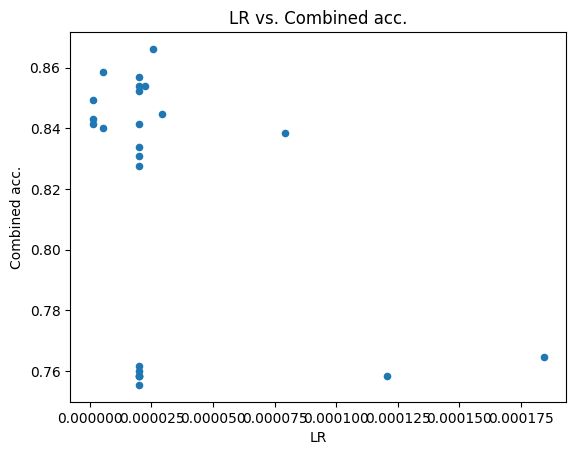

In [23]:
# !pip install matplotlib
import matplotlib.pyplot as plt

# Plotting the columns 'LR' and 'Combined acc.'
results[results['LR'] < 0.0002][results['Year'] == 2016].plot(x='LR', y='Combined acc.', kind='scatter')

# Adding labels and title
plt.xlabel('LR')
plt.ylabel('Combined acc.')
plt.title('LR vs. Combined acc.')

# Displaying the plot
plt.show()

In [ ]:
d = np.random.choice([0.1, 0.2, 0.4])
type(d)